## Visualization using Sliding Windows

### Imports

In [50]:
import csv
import math

import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

import numpy as np

from keras import applications
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input
from keras.initializers import glorot_uniform
from keras.applications.vgg16 import preprocess_input

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Load Neural Network with Regression Output

In [3]:
# Hyperparameters

num_settings = 1

hp_dropout = [0.2] * num_settings

#RMSprop
hp_lr = [0.001] * num_settings
hp_rho = [0.9] * num_settings
hp_epsilon = [1e-07] * num_settings
hp_decay = [0.0] * num_settings

# Number of hidden units
hp_hidden = [256] * num_settings

# Minibatch size
hp_mbsize = [64] * num_settings

num_epochs = 20

In [4]:
setting = 0

input_tensor = Input(shape=(224,224,3))
model = applications.VGG16(weights='imagenet', include_top=False, input_tensor = input_tensor)

# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=(model.output_shape[1:])))


# Output layer
# We do random weight intialization
top_model.add(Dropout(hp_dropout[setting]))
top_model.add(Dense(hp_hidden[setting], activation='relu', kernel_initializer='glorot_uniform'))
top_model.add(Dense(1, activation='linear', name='output', kernel_initializer='glorot_uniform'))

# add the model on top of the convolutional base
new_model = Model(inputs=model.input, outputs=top_model(model.output))

# load our weights into the model
new_model.load_weights('../datasets/bikes-cnn-best.hdf5')

### Sliding Windows Visualization

We select a series of images and overlay a sliding window of gray (average) pixel value over each image, retrieving the neural network prediction. 

The sliding window runs through window sizes of 28x28, for a total of 64 iterations for a 224x224 image.

For each image, we visualize the effect of the sliding window on the predicted price using a heatmap.

In [26]:
image_indices = ['32', '3652', '7382', '42909', '66903', '67929']
num_originals = len(image_indices)

In [27]:
pre_sliding_images = np.zeros((num_originals, 224, 224, 3))

# load images from files
for i in range(num_originals): 
    img = image.load_img('../datasets/bikes_im/' + image_indices[i] + '.jpg',
                         target_size=(224, 224))
    pre_sliding_images[i, :, :, :] = image.img_to_array(img)

# preprocess for VGG
pre_sliding_images = preprocess_input(pre_sliding_images)

sliding_window_images = np.zeros((num_originals, 64, 224, 224, 3))
for orig_ind in range(num_originals):
    for i in range(int(224/28)):    
        for j in range(int(224/28)):   

            start_i = i * 28
            end_i = start_i + 28
            start_j = j * 28
            end_j = start_j + 28

            pixels = np.copy(pre_sliding_images[orig_ind, :, :, :]).reshape((224, 224, 3))

            pixels[start_i:end_i, start_j:end_j] = (117, 117, 117) # set the color accordingly

            sliding_ind = i*8 + j
            sliding_window_images[orig_ind, sliding_ind, :, :, :] = pixels

In [28]:
sliding_window_images.shape

(6, 64, 224, 224, 3)

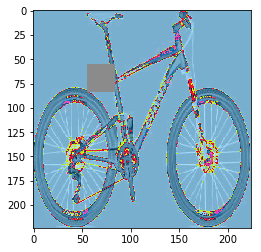

In [69]:
plt.imshow(sliding_window_images[3, 18, :, :, :])

In [30]:
heatmaps = np.zeros((num_originals, 8, 8))

for orig_ind in range(num_originals):
    orig_prediction = new_model.predict(np.expand_dims(pre_sliding_images[orig_ind], axis=0))
    
    nn_input = sliding_window_images[orig_ind].reshape((64, 224, 224, 3))
    predictions = new_model.predict(nn_input)
    heatmaps[orig_ind] = predictions.reshape((8, 8)) - orig_prediction

In [ ]:
# This dictionary defines the colormap
cdict = {'red':  ((0.0, 0.0, 0.0),   # no red at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.8, 0.8)),  # set to 0.8 so its not too bright at 1

        'green': ((0.0, 0.8, 0.8),   # set to 0.8 so its not too bright at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.0, 0.0)),  # no green at 1

        'blue':  ((0.0, 0.0, 0.0),   # no blue at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.0, 0.0))   # no blue at 1
       }

# Create the colormap using the dictionary
GnRd = colors.LinearSegmentedColormap('GnRd', cdict)

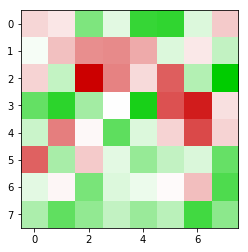

In [70]:
plt.imshow(heatmaps[3], cmap=GnRd, interpolation='nearest')

In [54]:
print(heatmaps[1])

[[ -4.21630859e+00   4.43353271e+00  -2.43413086e+01  -6.11492767e+01
   -2.17006836e+01  -1.12728882e+01   9.88073730e+00   1.06445312e-01]
 [  1.19964905e+01   1.02654724e+01  -6.02676086e+01  -5.36035767e+01
   -1.73024750e+01   9.05847473e+01  -6.81033325e+00  -5.04364014e+00]
 [  1.82887268e+01   3.76528931e+01   5.08429565e+01  -2.55007935e+01
    1.89451904e+01   1.42539062e+01   4.98413086e-01  -1.80681763e+01]
 [  2.45433350e+01   6.09686279e+01   1.45855713e+00  -3.49975586e+00
    3.33842163e+01  -7.35848999e+00  -2.76821289e+01  -6.48571777e+00]
 [  2.95623779e+01   9.28817749e+00  -1.78921509e+00   4.04567261e+01
   -3.56453552e+01  -3.21124420e+01  -7.25769043e-01  -2.55060120e+01]
 [  4.32753296e+01   4.41655273e+01  -4.79897766e+01  -1.68124084e+01
   -7.21878052e+00  -2.11345825e+01  -2.23710632e+01  -1.25631104e+01]
 [ -7.14584351e+00  -2.63150330e+01  -1.04974060e+01   3.72540283e+00
    8.82476807e-01  -1.80823517e+01  -2.64862366e+01   3.15411377e+00]
 [  1.4626831